<a href="https://colab.research.google.com/github/undisputedcoder/Hot-Dog-or-Pizza/blob/master/hot_dog_or_pizza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Model for Classifying 🌭 and 🍕 

### Import the neccessary libraries

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import numpy as np
import pathlib
import os

from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
print(tf.__version__)

2.8.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocess the dataset


---



### Loading the images and splitting dataset
Load the images from the dataset and separate into training and test set(s). Of the training set, 20% is reserved for the validation set.

In [4]:
IMG_SIZE = 200
BATCH_SIZE = 32

data_dir = pathlib.Path("/content/drive/MyDrive/food")

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE)

class_names = train_ds.class_names


Found 826 files belonging to 2 classes.
Using 661 files for training.
Found 826 files belonging to 2 classes.
Using 165 files for validation.


### Data augmentation

Added extra images to the dataset by 

* flipping,
* rotating,
* and zooming

A neat trick to increase the size of the dataset.

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

## Defining the model

Create the model using Sequential API.

In [6]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, (3,3), activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(64, (3,3) , activation='relu'),
  layers.MaxPooling2D(2,2),

  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 200, 200, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                  

## Compile and fit the model

Define the loss function and optimizer and train the model. The Adam optimizer was chosen to keep things simple. The **Binary Crossentropy** loss function was used because there are only two outputs possible (hot dog or pizza) in the model.

❗ A GPU was used for training the model faster. A CPU will be much slower.


In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['binary_accuracy'])

epochs=100

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
21/21 [==============================] - 74s 624ms/step - loss: 0.6808 - binary_accuracy: 0.6672 - val_loss: 0.6498 - val_binary_accuracy: 0.6848
Epoch 2/100
21/21 [==============================] - 2s 103ms/step - loss: 0.6205 - binary_accuracy: 0.6868 - val_loss: 0.5875 - val_binary_accuracy: 0.6909
Epoch 3/100
21/21 [==============================] - 2s 98ms/step - loss: 0.5734 - binary_accuracy: 0.7216 - val_loss: 0.5591 - val_binary_accuracy: 0.7030
Epoch 4/100
21/21 [==============================] - 2s 92ms/step - loss: 0.5411 - binary_accuracy: 0.7201 - val_loss: 0.5782 - val_binary_accuracy: 0.7333
Epoch 5/100
21/21 [==============================] - 2s 92ms/step - loss: 0.5219 - binary_accuracy: 0.7519 - val_loss: 0.6265 - val_binary_accuracy: 0.6121
Epoch 6/100
21/21 [==============================] - 2s 91ms/step - loss: 0.5184 - binary_accuracy: 0.7458 - val_loss: 0.5430 - val_binary_accuracy: 0.7273
Epoch 7/100
21/21 [==============================] - 2s 93ms/

In [8]:
model.save('/content/drive/MyDrive/model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model/assets


## Evaluate and plot results

Plot the results of training on a graph to visualise the accuracy.

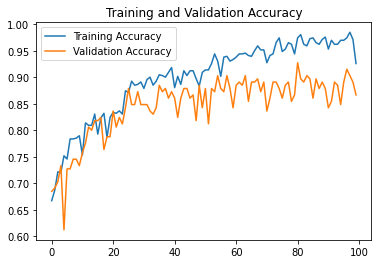

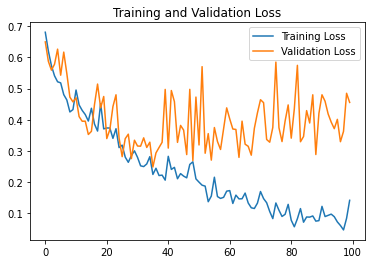

In [9]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss')
plt.show()

## Prediction

Use the trained model to make a prediction

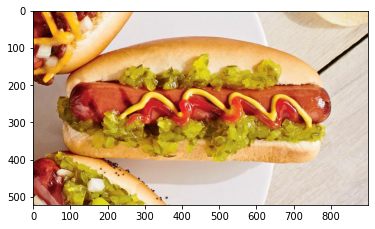

In [20]:
img_path = pathlib.Path("/content/drive/MyDrive/test0.jpg")

img = mpimg.imread(img_path)
plt.imshow(img)

In [21]:
img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to hot dog with a 100.00 percent confidence.
